## Random Forest - pair distribution function (PDF) - number of atoms - regression

In [37]:
import numpy as np
import pandas as pd
import h5py
from debyecalculator import DebyeCalculator
from ase.io import read
import glob
import os
import sys
import random
import tiktoken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

random.seed(42)
np.random.seed(42)

In [2]:
def process_xyz_files():
    # Initialise DebyeCalculator object
    calc = DebyeCalculator()
    print(calc)
    
    # Load XYZ files
    XYZ_files = sorted(glob.glob("../xyz_files/*.xyz"))
    random.shuffle(XYZ_files)

    # Calculate Pair Distribution Function for all XYZ files
    scattering_files = []
    structure_types = []
    num_atoms = []

    for iter, xyz_file in enumerate(XYZ_files):
        # Extract structure type
        structure_type = os.path.basename(xyz_file).split('_')[0]

        # Calculate the scattering pattern
        scatt_x, scatt_Int = calc.gr(structure_source=xyz_file)

        # Normalise the scattering files
        scatt_Int /= max(scatt_Int)
        scattering_files.append(scatt_Int)

        # Increment the count for this structure type
        structure_types.append(structure_type)

        atoms = read(xyz_file)
        num_atoms.append(len(atoms))

    return scattering_files, structure_types, num_atoms

In [3]:
# Simulate scattering data
scattering_files, structure_types, num_atoms = process_xyz_files()

/tmp/ipykernel_12297/1612413307.py:3: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator()


DebyeCalculator{'qmin': 1.0, 'qmax': 30.0, 'qdamp': 0.04, 'qstep': 0.05, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


In [4]:
len(scattering_files[0])

2000

In [5]:
np.set_printoptions(threshold=sys.maxsize)

In [6]:
scattering_files[0]

array([ 0.00000000e+00, -1.24081259e-03, -2.43981788e-03, -3.55886901e-03,
       -4.56686504e-03, -5.44242794e-03, -6.17583841e-03, -6.76981779e-03,
       -7.23938225e-03, -7.61045050e-03, -7.91762862e-03, -8.20107665e-03,
       -8.50310456e-03, -8.86432454e-03, -9.32015758e-03, -9.89775546e-03,
       -1.06134415e-02, -1.14714708e-02, -1.24634868e-02, -1.35693504e-02,
       -1.47587219e-02, -1.59940217e-02, -1.72333848e-02, -1.84345916e-02,
       -1.95586290e-02, -2.05732044e-02, -2.14555021e-02, -2.21943278e-02,
       -2.27909349e-02, -2.32591350e-02, -2.36239322e-02, -2.39193980e-02,
       -2.41856966e-02, -2.44655330e-02, -2.48004626e-02, -2.52271071e-02,
       -2.57741194e-02, -2.64594071e-02, -2.72887163e-02, -2.82550789e-02,
       -2.93392893e-02, -3.05116437e-02, -3.17345411e-02, -3.29658240e-02,
       -3.41622792e-02, -3.52836587e-02, -3.62959877e-02, -3.71749178e-02,
       -3.79074812e-02, -3.84935588e-02, -3.89457569e-02, -3.92884202e-02,
       -3.95554863e-02, -

In [7]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0])))
num_tokens

19524

In [8]:
len(scattering_files[0].round(3)[::15])

134

In [9]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0].round(3)[::15])))
num_tokens

551

### distribution of num of atoms values in the dataset

(array([285., 247., 228., 171., 171., 209., 133., 152., 171., 190.]),
 array([  6. ,  15.4,  24.8,  34.2,  43.6,  53. ,  62.4,  71.8,  81.2,
         90.6, 100. ]),
 <BarContainer object of 10 artists>)

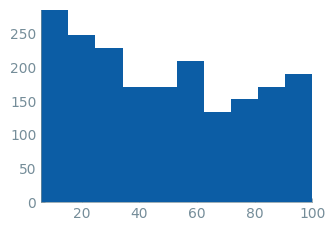

In [10]:
plt.figure(figsize=(3.5, 2.5))
plt.hist(num_atoms)

In [11]:
scattering_patterns = []

In [12]:
for i in np.arange(len(scattering_files)):
    pattern = scattering_files[i].round(3)[::15]
    scattering_patterns.append(pattern)

In [13]:
len(scattering_patterns[0])

134

### prepare regression dataset for number of atoms

In [14]:
scattering_patterns = np.array(scattering_patterns)
num_atoms = np.array(num_atoms)

In [15]:
THRESHOLD_num = 60

In [16]:
num_atoms_binned = np.array([1 if value > THRESHOLD_num else 0 for value in num_atoms])
num_atoms_binned

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,

In [17]:
np.unique(num_atoms_binned, return_counts=True)

(array([0, 1]), array([1311,  646]))

In [25]:
MAX_TEST_DATA = 2000
train_size = 1800

In [26]:
indices = np.arange(len(num_atoms))
indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [27]:
train_indices, test_indices = train_test_split(
    indices, 
    train_size=train_size, 
    test_size=min(len(indices)-train_size, MAX_TEST_DATA),
    random_state=42,
    stratify=num_atoms_binned
)

In [28]:
len(train_indices)

1800

In [29]:
len(test_indices)

157

In [30]:
X_train, y_train = scattering_patterns[train_indices], num_atoms[train_indices]
X_test, y_test = scattering_patterns[test_indices], num_atoms[test_indices]

In [31]:
np.unique(y_train, return_counts=True)

(array([  6,   7,   8,   9,  10,  12,  13,  14,  15,  16,  18,  19,  20,
         23,  24,  25,  27,  28,  29,  30,  32,  33,  35,  36,  39,  40,
         42,  43,  44,  48,  49,  50,  51,  54,  55,  56,  57,  59,  60,
         63,  64,  70,  71,  72,  75,  80,  81,  83,  84,  85,  87,  89,
         90,  93,  95,  96,  98, 100]),
 array([34, 35, 35, 19, 19, 34, 51, 17, 19, 52, 35, 51, 16, 18, 56, 33, 31,
        19, 18, 17, 49, 35, 19, 37, 18, 53, 15, 18, 17, 68, 18, 19, 36, 36,
        34, 37, 37, 18, 33, 35, 52, 18, 18, 52, 15, 55, 19, 18, 35, 36, 36,
        19, 16, 32, 18, 70, 16, 34]))

In [32]:
np.unique(y_test, return_counts=True)

(array([  6,   7,   8,  12,  13,  14,  16,  18,  19,  20,  23,  24,  25,
         27,  29,  30,  32,  33,  36,  39,  40,  42,  43,  44,  48,  49,
         51,  54,  55,  56,  57,  59,  60,  63,  64,  70,  71,  72,  75,
         80,  83,  84,  85,  87,  90,  93,  95,  96,  98, 100]),
 array([4, 3, 3, 4, 6, 2, 5, 3, 6, 3, 1, 1, 5, 7, 1, 2, 8, 3, 1, 1, 4, 4,
        1, 2, 8, 1, 2, 2, 4, 1, 1, 1, 5, 3, 5, 1, 1, 5, 4, 2, 1, 3, 2, 2,
        3, 6, 1, 6, 3, 4]))

In [33]:
X_train[0]

array([ 0.   , -0.013, -0.023, -0.034, -0.047, -0.057, -0.066, -0.077,
       -0.087, -0.092, -0.101, -0.111, -0.114, -0.115, -0.124, -0.045,
        0.838,  0.499, -0.101, -0.133, -0.126, -0.119, -0.096,  0.086,
       -0.021, -0.098, -0.026,  0.105,  0.108, -0.014, -0.063,  0.069,
        0.038, -0.039, -0.047, -0.04 , -0.033, -0.028, -0.022, -0.016,
       -0.012, -0.008, -0.004, -0.   ,  0.002,  0.005,  0.007,  0.008,
        0.009,  0.011,  0.011,  0.01 ,  0.011,  0.01 ,  0.009,  0.008,
        0.007,  0.006,  0.004,  0.003,  0.003,  0.001, -0.   , -0.001,
       -0.002, -0.003, -0.004, -0.004, -0.005, -0.005, -0.005, -0.005,
       -0.006, -0.005, -0.004, -0.004, -0.004, -0.003, -0.002, -0.002,
       -0.001, -0.   ,  0.   ,  0.001,  0.002,  0.002,  0.002,  0.003,
        0.003,  0.003,  0.003,  0.004,  0.003,  0.003,  0.003,  0.003,
        0.002,  0.002,  0.002,  0.001,  0.001,  0.   ,  0.   , -0.   ,
       -0.001, -0.001, -0.001, -0.002, -0.002, -0.002, -0.002, -0.002,
      

### train and evaluate regressor

In [38]:
reg = RandomForestRegressor(
    n_estimators=500, 
    random_state=42, 
    verbose=True
)

In [39]:
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   27.0s


RandomForestRegressor(n_estimators=500, random_state=42, verbose=True)

In [40]:
y_pred = reg.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


array([70.504, 57.902, 30.35 , 78.112, 68.242, 86.316, 75.33 , 28.042,
       65.476, 20.712, 66.23 , 67.192, 35.58 , 85.506, 68.758,  9.296,
       40.274, 66.152, 57.832, 85.8  , 18.796, 12.93 , 69.436, 69.93 ,
       76.67 , 58.056, 23.646, 49.674, 22.482, 74.97 , 31.318, 82.146,
       18.114, 15.298, 80.026, 51.064, 46.984, 55.792, 56.146, 83.208,
       28.94 , 77.412,  6.336, 39.73 , 80.146, 43.204, 16.322, 43.176,
       80.69 , 54.906, 55.6  , 23.606, 53.088, 38.44 , 28.998, 24.304,
       81.75 , 22.484, 12.402, 33.418, 18.812, 70.16 , 27.186, 84.808,
       36.524, 57.538, 29.064,  9.328, 34.54 , 77.03 , 78.744, 14.578,
       81.22 , 64.182, 75.518, 25.752, 28.736, 42.536, 84.692, 42.626,
       14.294, 12.974, 57.72 , 48.84 , 45.408, 12.992, 46.036, 78.942,
       23.192, 15.082, 30.968,  6.138, 58.168, 55.486, 53.204, 76.668,
       81.138, 81.104, 40.174, 43.126, 69.518, 25.37 , 42.318, 78.248,
        9.37 ,  9.134, 13.542, 49.078, 41.908, 13.17 , 52.054, 19.412,
      

In [41]:
y_test

array([ 83,  55,  27,  93,  60,  84,  63,  32,  60,  20,  64,  60,  32,
        85,  57,   6,  51,  60,  64,  98,  16,  13,  75,  63,  72,  64,
        24,  49,  25,  96,  32,  96,  18,  12,  96,  48,  48,  55,  48,
        95,  32,  72,   6,  36,  87,  40,  13,  42,  87,  48,  55,  25,
        48,  32,  27,  18,  98,  23,  12,  33,  19,  63,  25,  98,  27,
        71,  29,   8,  33,  75,  72,  14,  93,  54,  90,  19,  27,  42,
        84,  39,  16,  13,  27,  48,  43,  13,  40,  90,  19,  16,  25,
         6,  54,  44,  51,  80,  72, 100,  32,  40,  80,  25,  42,  90,
         8,   8,  13,  48,  40,  13,  59,  20,  27,  96,  96,  70,  12,
       100,  14,  96,  32,  55,   7,  12,  33,  72,  64,  48,  27,  32,
        85,  84,  93,  56,  19,   7,  19,  75,  16,  30,  93,  93, 100,
        93,  18,  30,  64,  20,  42,   7, 100,   6,  44,  19,  16,  60,
        75])

In [42]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

In [43]:
r2, mae, rmse

(0.9287845565882852, 5.275885350318471, 7.769458870073125)

In [45]:
def prepare_dataset_regression(
    scattering_patterns, 
    num_atoms, 
    max_test_data=100, 
    THRESHOLD_num = 60, 
    train_size = 250, 
    random_state=42
):
        # Convert scattering_files to a NumPy array
    scattering_patterns = np.array(scattering_patterns)
    # Ensure num_atoms is also a NumPy array
    num_atoms = np.array(num_atoms)
    
    # Create variable to stratify when creating train, validation and test sets
    num_atoms_binned = np.array([1 if value > THRESHOLD_num else 0 for value in num_atoms])
    
    # Split the samples into train and test sets
    indices = np.arange(len(num_atoms))
    train_indices, test_indices = train_test_split(
        indices, 
        train_size=train_size, 
        test_size=min(len(indices)-train_size, max_test_data),
        random_state=random_state,
        stratify=num_atoms_binned
    )
    
    print(f"train: {len(train_indices)}")
    print(f"test: {len(test_indices)}")
    
    # Create the training and test sets
    X_train, y_train = scattering_patterns[train_indices], num_atoms[train_indices]
    X_test, y_test = scattering_patterns[test_indices], num_atoms[test_indices]
    
    return X_train, y_train, X_test, y_test

In [46]:
def train_and_evaluate_regressor(X_train, y_train, X_test, y_test, random_state=42):
    # Create a regressor
    reg = RandomForestRegressor(
        n_estimators=500, 
        random_state=42, 
        verbose=True
    )
    
    # Train the regressor with early stopping
    reg.fit(X_train, y_train)
    
    # Predict the test set results
    y_pred = reg.predict(X_test)
    
    y_test = np.array(y_test)
    
    # Calculate regression metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return y_test, y_pred, r2, mae, rmse

In [47]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "mae": mae_scores,
        "rmse": rmse_scores,
        "r2": r2_scores
    }
    return metrics_dict

### training size = 600

In [48]:
train_size = 600
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [49]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 600
test: 100
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8526621404036545
MAE for number of atoms regression: 7.4753
RMSE for number of atoms regression: 10.445617230207125
-------------Iteration 2/10
train: 600
test: 100
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8180873724668092
MAE for number of atoms regression: 8.519820000000003
RMSE for number of atoms regression: 11.728432364131193
-------------Iteration 3/10
train: 600
test: 100
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8155158297752446
MAE for number of atoms regression: 9.0831
RMSE for number of atoms regression: 12.089073706450796
-------------Iteration 4/10
train: 600
test: 100
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.7807323870573721
MAE for number of atoms regression: 8.41736
RMSE for number of atoms regression: 11.631020598382586
-------------Iteration 5/10
train: 600
test: 100
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.829696473362321
MAE for number of atoms regression: 8.3544
RMSE for number of atoms regression: 11.453131917514964
-------------Iteration 6/10
train: 600
test: 100
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8654399022220534
MAE for number of atoms regression: 6.92586
RMSE for number of atoms regression: 10.34305384497248
-------------Iteration 7/10
train: 600
test: 100
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8300416446361986
MAE for number of atoms regression: 7.94456
RMSE for number of atoms regression: 11.513652157330444
-------------Iteration 8/10
train: 600
test: 100
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8627765989208567
MAE for number of atoms regression: 7.878539999999998
RMSE for number of atoms regression: 10.728336857127482
-------------Iteration 9/10
train: 600
test: 100
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8437033157453127
MAE for number of atoms regression: 8.2968
RMSE for number of atoms regression: 11.622705654020496
-------------Iteration 10/10
train: 600
test: 100
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    9.1s


R2 for number of atoms regression: 0.8799840914379174
MAE for number of atoms regression: 6.935839999999998
RMSE for number of atoms regression: 9.691509178657368


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [50]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 600
mean R2 for number of atoms regression: 0.8378639756027739 +/- 0.027732160536255115
mean MAE for number of atoms regression: 7.983158 +/- 0.663905892635395
mean RMSE for number of atoms regression: 11.124653350879493 +/- 0.730841615376173


In [51]:
compiled_res_600 = pd.DataFrame(metrics_dict())
compiled_res_600.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[56, 44, 36, 8, 96, 20, 55, 36, 87, 75, 100, 7...","[51.782, 40.204, 52.284, 10.306, 79.314, 26.28...",7.47530,10.445617,0.852662
1,600,"[20, 57, 39, 64, 28, 95, 28, 7, 60, 23, 9, 63,...","[17.83, 70.072, 36.68, 57.28, 27.05, 65.076, 2...",8.51982,11.728432,0.818087
2,600,"[24, 57, 9, 85, 100, 29, 16, 40, 83, 27, 57, 5...","[39.158, 55.17, 11.276, 71.928, 84.498, 29.148...",9.08310,12.089074,0.815516


### training size = 1000

In [52]:
train_size = 1000
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [53]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1000
test: 100
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.882804514181462
MAE for number of atoms regression: 7.0637599999999985
RMSE for number of atoms regression: 9.393417576154059
-------------Iteration 2/10
train: 1000
test: 100
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   15.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9187706565618491
MAE for number of atoms regression: 6.2046
RMSE for number of atoms regression: 8.464714317683734
-------------Iteration 3/10
train: 1000
test: 100
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8943103544677131
MAE for number of atoms regression: 6.444020000000002
RMSE for number of atoms regression: 9.425616743746797
-------------Iteration 4/10
train: 1000
test: 100
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8735998387479604
MAE for number of atoms regression: 7.314220000000001
RMSE for number of atoms regression: 10.572579721146585
-------------Iteration 5/10
train: 1000
test: 100
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8721661243061629
MAE for number of atoms regression: 7.157400000000001
RMSE for number of atoms regression: 10.06917669722803
-------------Iteration 6/10
train: 1000
test: 100
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8786916244154117
MAE for number of atoms regression: 6.922860000000001
RMSE for number of atoms regression: 10.229619021253919
-------------Iteration 7/10
train: 1000
test: 100
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8640206966821727
MAE for number of atoms regression: 7.13658
RMSE for number of atoms regression: 10.167312346928268
-------------Iteration 8/10
train: 1000
test: 100
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8932717903764729
MAE for number of atoms regression: 6.564040000000001
RMSE for number of atoms regression: 8.88238112219916
-------------Iteration 9/10
train: 1000
test: 100
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8910530773675245
MAE for number of atoms regression: 6.619699999999999
RMSE for number of atoms regression: 9.810267998378025
-------------Iteration 10/10
train: 1000
test: 100
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   14.8s


R2 for number of atoms regression: 0.8897534523798915
MAE for number of atoms regression: 7.176580000000001
RMSE for number of atoms regression: 9.69641711355282


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [54]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1000
mean R2 for number of atoms regression: 0.8858442129486621 +/- 0.014584545008939348
mean MAE for number of atoms regression: 6.8603760000000005 +/- 0.35565081142041555
mean RMSE for number of atoms regression: 9.67115026582714 +/- 0.6135244932287861


In [55]:
compiled_res_1000 = pd.DataFrame(metrics_dict())
compiled_res_1000.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1000,"[15, 12, 72, 44, 72, 33, 8, 7, 13, 60, 27, 60,...","[12.234, 16.536, 80.648, 51.364, 75.132, 35.80...",7.06376,9.393418,0.882805
1,1000,"[24, 60, 96, 89, 40, 57, 63, 6, 12, 48, 9, 24,...","[19.448, 68.622, 72.006, 82.392, 41.586, 65.30...",6.20460,8.464714,0.918771
2,1000,"[35, 32, 36, 57, 40, 9, 54, 95, 13, 80, 19, 95...","[40.53, 40.784, 47.632, 62.832, 44.702, 10.742...",6.44402,9.425617,0.894310


### training size = 1400

In [56]:
train_size = 1400
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [57]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1400
test: 100
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9165645527171188
MAE for number of atoms regression: 6.1765
RMSE for number of atoms regression: 8.582573961230977
-------------Iteration 2/10
train: 1400
test: 100
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.8966708459219894
MAE for number of atoms regression: 7.2125
RMSE for number of atoms regression: 9.623664206527573
-------------Iteration 3/10
train: 1400
test: 100
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9315768976212258
MAE for number of atoms regression: 5.61556
RMSE for number of atoms regression: 7.890938144479399
-------------Iteration 4/10
train: 1400
test: 100
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9340956703023853
MAE for number of atoms regression: 5.2176800000000005
RMSE for number of atoms regression: 7.341151212173742
-------------Iteration 5/10
train: 1400
test: 100
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9073961557584174
MAE for number of atoms regression: 6.315659999999999
RMSE for number of atoms regression: 9.019766145527278
-------------Iteration 6/10
train: 1400
test: 100
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9249423195274938
MAE for number of atoms regression: 5.7267399999999995
RMSE for number of atoms regression: 8.16221539289426
-------------Iteration 7/10
train: 1400
test: 100
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9208566153691831
MAE for number of atoms regression: 5.876240000000001
RMSE for number of atoms regression: 8.102091680547685
-------------Iteration 8/10
train: 1400
test: 100
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9320650779729442
MAE for number of atoms regression: 4.94386
RMSE for number of atoms regression: 7.066663396540124
-------------Iteration 9/10
train: 1400
test: 100
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.928182059454092
MAE for number of atoms regression: 5.85346
RMSE for number of atoms regression: 7.535473747548988
-------------Iteration 10/10
train: 1400
test: 100
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   21.6s


R2 for number of atoms regression: 0.9138920024836943
MAE for number of atoms regression: 5.82912
RMSE for number of atoms regression: 8.165539795996343


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [58]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1400
mean R2 for number of atoms regression: 0.9206242197128545 +/- 0.011483487032548534
mean MAE for number of atoms regression: 5.876732 +/- 0.5886350010116626
mean RMSE for number of atoms regression: 8.149007768346637 +/- 0.7342060851192671


In [59]:
compiled_res_1400 = pd.DataFrame(metrics_dict())
compiled_res_1400.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1400,"[64, 49, 84, 18, 16, 10, 27, 55, 96, 84, 24, 8...","[57.374, 48.344, 79.764, 17.288, 16.964, 12.59...",6.17650,8.582574,0.916565
1,1400,"[100, 16, 32, 63, 87, 23, 14, 13, 89, 19, 100,...","[71.502, 16.956, 26.898, 77.206, 79.448, 22.43...",7.21250,9.623664,0.896671
2,1400,"[43, 12, 16, 64, 18, 48, 72, 55, 12, 43, 90, 2...","[41.764, 10.942, 18.218, 55.558, 21.652, 42.27...",5.61556,7.890938,0.931577


### training size = 1800

In [60]:
train_size = 1800
iterations = 10
y_test_all = []
y_pred_all = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [61]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for regression
    X_train, y_train, X_test, y_test = prepare_dataset_regression(
        scattering_patterns, 
        num_atoms, 
        THRESHOLD_num = 60, 
        train_size = train_size,
        random_state = random_state
    )
    print(f"random_state = {random_state}")

    # Regression of number of atoms
    y_test, y_pred, r2, mae, rmse = train_and_evaluate_regressor(
        X_train, 
        y_train, 
        X_test, 
        y_test,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"R2 for number of atoms regression: {r2}")
    print(f"MAE for number of atoms regression: {mae}")
    print(f"RMSE for number of atoms regression: {rmse}")

-------------Iteration 1/10
train: 1800
test: 100
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9341664925300217
MAE for number of atoms regression: 5.0501
RMSE for number of atoms regression: 7.414816974140359
-------------Iteration 2/10
train: 1800
test: 100
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9250635873568395
MAE for number of atoms regression: 5.51424
RMSE for number of atoms regression: 7.846655639187945
-------------Iteration 3/10
train: 1800
test: 100
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.933931220959546
MAE for number of atoms regression: 4.7465
RMSE for number of atoms regression: 7.075097910276578
-------------Iteration 4/10
train: 1800
test: 100
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9425492712065972
MAE for number of atoms regression: 4.76332
RMSE for number of atoms regression: 6.855307993080983
-------------Iteration 5/10
train: 1800
test: 100
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   29.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.944275599763329
MAE for number of atoms regression: 4.8191999999999995
RMSE for number of atoms regression: 6.5669760651307385
-------------Iteration 6/10
train: 1800
test: 100
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9237550815625948
MAE for number of atoms regression: 5.61938
RMSE for number of atoms regression: 7.78237671408934
-------------Iteration 7/10
train: 1800
test: 100
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9224684949078731
MAE for number of atoms regression: 5.043040000000001
RMSE for number of atoms regression: 7.447238135040399
-------------Iteration 8/10
train: 1800
test: 100
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9262580558798558
MAE for number of atoms regression: 5.52972
RMSE for number of atoms regression: 8.13797998522975
-------------Iteration 9/10
train: 1800
test: 100
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


R2 for number of atoms regression: 0.9495996021138057
MAE for number of atoms regression: 4.146999999999999
RMSE for number of atoms regression: 5.978404148265655
-------------Iteration 10/10
train: 1800
test: 100
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   28.2s


R2 for number of atoms regression: 0.9186749870909365
MAE for number of atoms regression: 5.54536
RMSE for number of atoms regression: 7.930204057904185


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [62]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean R2 for number of atoms regression: {np.mean(r2_scores)} +/- {np.std(r2_scores)}")
print(f"mean MAE for number of atoms regression: {np.mean(mae_scores)} +/- {np.std(mae_scores)}")
print(f"mean RMSE for number of atoms regression: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1800
mean R2 for number of atoms regression: 0.9320742393371398 +/- 0.009987790734751931
mean MAE for number of atoms regression: 5.077786 +/- 0.45282759589494986
mean RMSE for number of atoms regression: 7.303505762234593 +/- 0.6479118775003974


In [63]:
compiled_res_1800 = pd.DataFrame(metrics_dict())
compiled_res_1800.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,1800,"[25, 8, 25, 55, 32, 27, 84, 93, 93, 48, 23, 32...","[25.37, 9.328, 23.606, 55.6, 31.318, 36.524, 8...",5.05010,7.414817,0.934166
1,1800,"[75, 80, 13, 59, 42, 19, 90, 16, 85, 72, 6, 63...","[75.516, 75.936, 12.838, 54.176, 42.654, 23.80...",5.51424,7.846656,0.925064
2,1800,"[32, 14, 39, 25, 24, 84, 59, 43, 19, 85, 54, 4...","[32.068, 17.13, 38.376, 39.006, 24.032, 82.464...",4.74650,7.075098,0.933931


In [64]:
compiled_res = pd.concat([
    compiled_res_600,
    compiled_res_1000,
    compiled_res_1400,
    compiled_res_1800
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

40


,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[56, 44, 36, 8, 96, 20, 55, 36, 87, 75, 100, 7...","[51.782, 40.204, 52.284, 10.306, 79.314, 26.28...",7.47530,10.445617,0.852662
1,600,"[20, 57, 39, 64, 28, 95, 28, 7, 60, 23, 9, 63,...","[17.83, 70.072, 36.68, 57.28, 27.05, 65.076, 2...",8.51982,11.728432,0.818087
2,600,"[24, 57, 9, 85, 100, 29, 16, 40, 83, 27, 57, 5...","[39.158, 55.17, 11.276, 71.928, 84.498, 29.148...",9.08310,12.089074,0.815516
3,600,"[7, 57, 80, 48, 48, 50, 48, 39, 42, 18, 72, 60...","[6.572, 43.166, 70.594, 45.56, 49.264, 57.988,...",8.41736,11.631021,0.780732
4,600,"[16, 29, 15, 40, 43, 18, 33, 96, 64, 80, 87, 3...","[23.166, 35.414, 14.646, 59.83, 45.888, 21.642...",8.35440,11.453132,0.829696


In [65]:
compiled_res["y_true"][0]

array([ 56,  44,  36,   8,  96,  20,  55,  36,  87,  75, 100,  72,  33,
        43,  16,  29,  75,  13,  48,  87,   8,  39,  39,  33,  80,  15,
        16,   8,  55,  40,  24,  29,  40,  87,  18,  96,  72,  51,  72,
        13,  13,  10,  25,  93,  16,  24,  24,  55,  33,   6,   8,  84,
        36,  55,  59,  35,  48,  32,  71,  64,  96,  35,  49,  80,   6,
        48,  87,  70,  40,  56,  10,  29,  36,  14,  51,  98,  95,  16,
        84,  72,  25,  33,  40,  96,  64,  85,  51,  63,  57,  43,  81,
        98,  54,  64,  83,  85,  51,  48,  55,  50])

In [66]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [67]:
compiled_res["y_true"][0]

[56,
 44,
 36,
 8,
 96,
 20,
 55,
 36,
 87,
 75,
 100,
 72,
 33,
 43,
 16,
 29,
 75,
 13,
 48,
 87,
 8,
 39,
 39,
 33,
 80,
 15,
 16,
 8,
 55,
 40,
 24,
 29,
 40,
 87,
 18,
 96,
 72,
 51,
 72,
 13,
 13,
 10,
 25,
 93,
 16,
 24,
 24,
 55,
 33,
 6,
 8,
 84,
 36,
 55,
 59,
 35,
 48,
 32,
 71,
 64,
 96,
 35,
 49,
 80,
 6,
 48,
 87,
 70,
 40,
 56,
 10,
 29,
 36,
 14,
 51,
 98,
 95,
 16,
 84,
 72,
 25,
 33,
 40,
 96,
 64,
 85,
 51,
 63,
 57,
 43,
 81,
 98,
 54,
 64,
 83,
 85,
 51,
 48,
 55,
 50]

In [68]:
compiled_res.to_csv("RF_results_regres_num_atoms.csv", sep=",", index=False)

In [69]:
df = pd.read_csv("RF_results_regres_num_atoms.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   train_size  40 non-null     int64  
 1   y_true      40 non-null     object 
 2   y_pred      40 non-null     object 
 3   mae         40 non-null     float64
 4   rmse        40 non-null     float64
 5   r2          40 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ KB


In [70]:
df.head(3)

,train_size,y_true,y_pred,mae,rmse,r2
0,600,"[56, 44, 36, 8, 96, 20, 55, 36, 87, 75, 100, 7...","[51.782, 40.204, 52.284, 10.306, 79.314, 26.28...",7.47530,10.445617,0.852662
1,600,"[20, 57, 39, 64, 28, 95, 28, 7, 60, 23, 9, 63,...","[17.83, 70.072, 36.68, 57.28, 27.05, 65.076, 2...",8.51982,11.728432,0.818087
2,600,"[24, 57, 9, 85, 100, 29, 16, 40, 83, 27, 57, 5...","[39.158, 55.17, 11.276, 71.928, 84.498, 29.148...",9.08310,12.089074,0.815516


In [71]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

mae                 rmse                  r2          
                mean       sem       mean       sem      mean       sem
train_size                                                             
600         7.983158  0.221302  11.124653  0.243614  0.837864  0.009244
1000        6.860376  0.118550   9.671150  0.204508  0.885844  0.004862
1400        5.876732  0.196212   8.149008  0.244735  0.920624  0.003828
1800        5.077786  0.150943   7.303506  0.215971  0.932074  0.003329

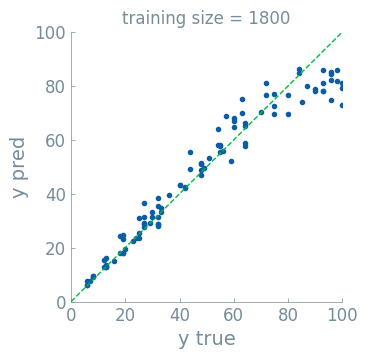

In [86]:
row=30
max_true = max(literal_eval(df.sort_values(['train_size']).iloc[row,1]))
max_pred = max(literal_eval(df.sort_values(['train_size']).iloc[row,2]))
plt.figure(figsize=(3.5, 3.5))
plt.scatter(literal_eval(df.sort_values(['train_size']).iloc[row,1]), 
            literal_eval(df.sort_values(['train_size']).iloc[row,2]),
           color='#0C5DA5')
plt.title(f"training size = {df.sort_values(['train_size']).iloc[row,0]}", fontsize=12)
plt.xlabel('y true', fontsize=14)
plt.ylabel('y pred', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot([0,max(max_true, max_pred)],[0,max(max_true, max_pred)], color='#00B945', linestyle='dashed')
plt.show()